___
this notebook select features that are important before throwing into the model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_selection import *
from sklearn import *
from scipy import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectFromModel, SelectPercentile
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from aggregate_function import build_features_table, combine_features_table, coach_stats, win_rate_type_of_location

/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be 

In [2]:
coach_file = 'data/DataFiles/TeamCoaches.csv'
regularseason_file = 'data/DataFiles/RegularSeasonDetailedResults.csv'
postseason_file = 'data/DataFiles/NCAATourneyCompactResults.csv'

In [3]:
# initial_features = build_features_table.BuildFeaturesTable(regularseason_file)
# win_rate_features = win_rate_type_of_location.WinRateTypeLocation(regularseason_file)
# coach_features = coach_stats.CoachStats(coach_file,regularseason_file,postseason_file)

features = combine_features_table.CombineFeaturesTable(coach_file,regularseason_file,postseason_file)

## Feature Selection on Correlation Matrix
- remove features that are highly correlated

In [46]:
features_table = (
    features.final_table_cum_processed
    .drop(['Season','TeamID'],1)
)

corr = features_table.corr()
features_table.corr(method='pearson').to_csv("output/cum_correlation_matrix.csv")

columns to be excluded
- total score
- total rebounds
- total blocks
- total assist turnover ratio
- E(X) per game
- win rate
- total rebound possession per game
- win_rate_overall coach

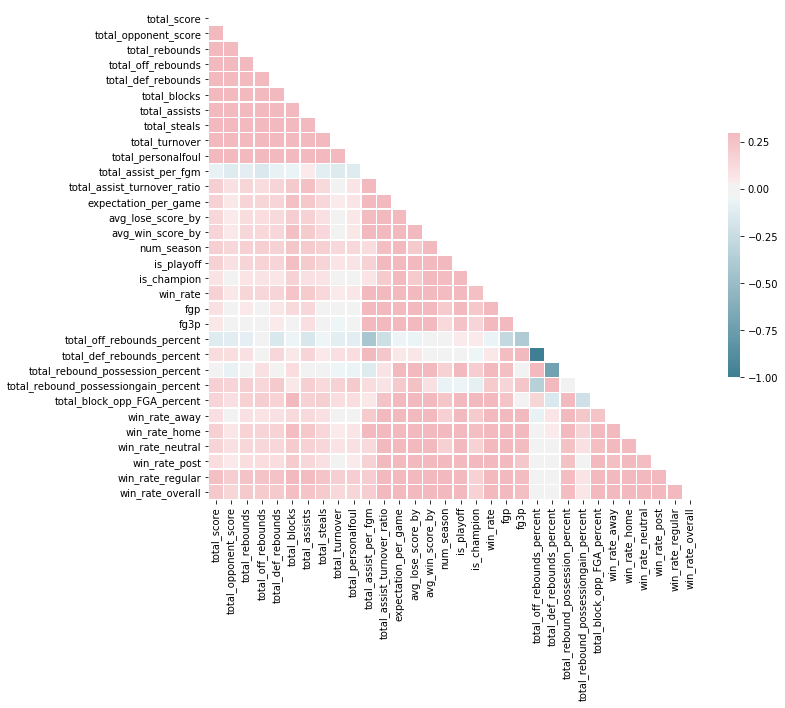

In [47]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [48]:
features_table = (
    features.final_table_cum_processed
    .drop(['Season','TeamID','total_score','total_opponent_score','total_rebounds','total_blocks','total_assist_turnover_ratio','expectation_per_game',
           'win_rate','fg3p','win_rate_overall','total_off_rebounds_percent','total_def_rebounds_percent','total_rebound_possession_percent','total_rebound_possessiongain_percent'
          ],1)
    .fillna(0)
)

## Feature selection from collinearity
- remove features that are collinearity
- features are then passed through variance threshold before passing into models for feature selection

In [49]:
vif = pd.DataFrame()
vif['VIF_factor'] = [variance_inflation_factor(features_table.values, i) for i in range(features_table.shape[1])]
vif['features'] = features_table.columns

features to further remove
- total_opponent_score
- total_rebound_possessiongain_percent 
- fg3p

In [27]:
features_table = (
    features.final_table_cum_processed
    .drop(['Season','TeamID','total_score','total_opponent_score','total_rebounds','total_blocks',
           'total_assist_turnover_ratio','expectation_per_game', 'win_rate','fg3p','win_rate_overall',
           'total_off_rebounds_percent','total_def_rebounds_percent','total_rebound_possession_percent',
           'total_rebound_possessiongain_percent'
          ],1)
    .fillna(0)
)

vif = pd.DataFrame()
vif['VIF_factor'] = [variance_inflation_factor(features_table.values, i) for i in range(features_table.shape[1])]
vif['features'] = features_table.columns
vif

,VIF_factor,features
0,158.743065,total_off_rebounds
1,481.989879,total_def_rebounds
2,301.891034,total_assists
3,131.456852,total_steals
4,342.763370,total_turnover
5,347.018625,total_personalfoul
6,29.795558,total_assist_per_fgm
7,139.193204,avg_lose_score_by
8,39.922220,avg_win_score_by
9,6.096839,num_season


## Feature selection from PCA explained variance
- use PCA to see how much variance does the feature account for, selecting up to 99% variance would be good enough
- 15 features are enough for variance
    - this doesnt tell us which features to discard but in the model selection of feature importance
    - we can tell the model to choose up to 9 features max

In [30]:
covar_matrix = PCA(n_components = 19)

covar_matrix.fit(features_table)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([ 47.9,  74.5,  81.3,  87.1,  90.7,  94. ,  96.2,  97.4,  98.2,
        98.8,  99.2,  99.4,  99.6,  99.8,  99.9, 100. , 100. , 100. , 100. ])

## Final data transformation for feature table
- post season is only what we care about
- post season match ups will be what we are joining all the features table to
- additional variable of seeding differential

In [34]:
features_table = (
    features.final_table_cum_processed
    .drop(['total_score','total_opponent_score','total_rebounds','total_blocks',
           'total_assist_turnover_ratio','expectation_per_game', 'win_rate','fg3p','win_rate_overall',
           'total_off_rebounds_percent','total_def_rebounds_percent','total_rebound_possession_percent',
           'total_rebound_possessiongain_percent'
          ],1)
    .fillna(0)
)

In [35]:
seeding_data = pd.read_csv("input/tour-results-seed.csv")

In [36]:
winning_team_perspective_df = (
    seeding_data
    .pipe(lambda x:x.assign(diff_seed = x.L_seed - x.W_seed))
    .pipe(lambda x:x.assign(outcome = 1))
    .merge(features_table,how='left',left_on=['Season','WTeamID'],right_on=['Season','TeamID'])
)

In [37]:
losing_team_perspective_df = (
    seeding_data
    .pipe(lambda x:x.assign(diff_seed = x.W_seed - x.L_seed))
    .pipe(lambda x:x.assign(outcome = 0))
    .merge(features_table,how='left',left_on=['Season','LTeamID'],right_on=['Season','TeamID'])
)

In [38]:
prediction_df = (
    winning_team_perspective_df.append(losing_team_perspective_df)
)

In [41]:
train_df = prediction_df.query("Season >= 2003 & Season <= 2016")
test_df = prediction_df.query("Season == 2017")

In [42]:
train_df.head()

,Season,WTeamID,W_seed,LTeamID,L_seed,diff_seed,outcome,total_off_rebounds,total_def_rebounds,total_assists,...,is_playoff,is_champion,TeamID,fgp,total_block_opp_FGA_percent,win_rate_away,win_rate_home,win_rate_neutral,win_rate_post,win_rate_regular
1136,2003,1421,16,1411,16,0,1,0.037785,0.035770,0.031439,...,0.03125,0.0,1421.0,0.429265,0.049208,0.500000,0.416667,1.00,0.500000,0.448276
1137,2003,1112,1,1436,16,15,1,0.047813,0.043772,0.045466,...,0.62500,0.2,1112.0,0.461413,0.065157,0.916667,0.933333,0.00,0.641509,0.892857
1138,2003,1113,10,1272,7,-3,1,0.043744,0.036084,0.040266,...,0.09375,0.0,1113.0,0.478182,0.076208,0.571429,0.666667,0.50,0.250000,0.620690
1139,2003,1141,11,1166,6,-5,1,0.030664,0.036006,0.040508,...,0.03125,0.0,1141.0,0.505236,0.069048,0.900000,0.687500,1.00,0.500000,0.793103
1140,2003,1143,8,1301,9,1,1,0.033425,0.038516,0.041838,...,0.21875,0.0,1143.0,0.465649,0.047507,0.875000,0.764706,0.25,0.500000,0.724138


## Feature selection of logistics regression
- RFE
- SelectFromModel

In [248]:
## RFE
train_data_x = train_df[['diff_seed','total_off_rebounds','total_def_rebounds','total_assists',
                         'total_steals','total_turnover','total_personalfoul','total_assist_per_fgm',
                         'avg_lose_score_by','avg_win_score_by','num_season','is_playoff','is_champion',
                         'fgp','total_block_opp_FGA_percent','win_rate_away','win_rate_home','win_rate_neutral',
                         'win_rate_post','win_rate_regular']]
train_data_y = train_df['outcome']
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 13)
fit = rfe.fit(train_data_x, train_data_y)
print("Num Features: "+ str(fit.n_features_))
print("Selected Features: " + str(fit.support_))
print("Feature Ranking: " + str(fit.ranking_))

Num Features: 13
Selected Features: [ True  True False  True False  True False  True  True  True False  True
  True False False  True  True False  True  True]
Feature Ranking: [1 1 2 1 6 1 7 1 1 1 8 1 1 4 3 1 1 5 1 1]


In [254]:
test_data_x = test_df[['diff_seed','total_off_rebounds','total_def_rebounds','total_assists',
                         'total_steals','total_turnover','total_personalfoul','total_assist_per_fgm',
                         'avg_lose_score_by','avg_win_score_by','num_season','is_playoff','is_champion',
                         'fgp','total_block_opp_FGA_percent','win_rate_away','win_rate_home','win_rate_neutral',
                         'win_rate_post','win_rate_regular']]
test_data_y = test_df['outcome']

In [255]:
rfe.score(test_data_x,test_data_y)

0.65671641791044777

In [256]:
new_train_data_x = train_df[['diff_seed','total_off_rebounds','total_assists',
                         'total_turnover','total_assist_per_fgm',
                         'avg_lose_score_by','avg_win_score_by','is_playoff','is_champion',
                         'win_rate_away','win_rate_home',
                         'win_rate_post','win_rate_regular']]

new_test_data_x = test_df[['diff_seed','total_off_rebounds','total_assists',
                         'total_turnover','total_assist_per_fgm',
                         'avg_lose_score_by','avg_win_score_by','is_playoff','is_champion',
                         'win_rate_away','win_rate_home',
                         'win_rate_post','win_rate_regular']]


## use features and run on RF
rf = RandomForestClassifier(random_state=0)
param_grid = {
         'n_estimators': [5,10,50,100,150,200,500,1000],
         'max_depth': [2,5,10]
     }

grid_rf = GridSearchCV(rf, param_grid, cv=5, verbose=2)
grid_rf.fit(new_train_data_x, train_data_y)

rf_model = grid_rf.best_estimator_
model = rf_model

model.score(new_test_data_x,test_data_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ............................ max_depth=2, n_estimators=5 -   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ........................... max_depth=2, n_estimators=10 -   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ........................... max_depth=2, n_estimators=50 -   0.1s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .......................... max_depth=2, n_estimators=100 -   0.1s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .......................... max_depth=2, n_estimators=100 -   0.1s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .

[CV] .......................... max_depth=5, n_estimators=200 -   0.3s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] .......................... max_depth=5, n_estimators=200 -   0.3s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.8s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.8s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.8s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.8s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .......................... max_depth=5, n_estimators=500 -   0.8s
[CV] max_depth=5, n_estimators=1000 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   54.0s finished


0.66417910447761197

In [278]:
model.predict(new_test_data_x)[:67]

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0])

In [ ]:
## SVM


## Feature selection of RF

In [4]:
def fx_test(input):
    print("test")
    if input == 1:
        return "true"
    else:
        return "false"

In [5]:
fx_test(1)

test


'true'

In [43]:
features_table.query("TeamID == 1455 & Season == 2014")

,total_off_rebounds,total_def_rebounds,total_assists,total_steals,total_turnover,total_personalfoul,total_assist_per_fgm,avg_lose_score_by,avg_win_score_by,num_season,...,is_champion,Season,TeamID,fgp,total_block_opp_FGA_percent,win_rate_away,win_rate_home,win_rate_neutral,win_rate_post,win_rate_regular
5031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.565544,0.482609,...,0.0,2014,1455,0.0,0.0,1.0,1.0,1.0,0.375,0.806667
